In [1]:
%matplotlib notebook
import numpy as np
np.random.seed(0)
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
from tqdm import tqdm
from ece import eceloss, uceloss
from utils import accuracy, nentr
from models import BayesianNet
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 8

In [2]:
model = 'densenet169'

In [3]:
batch_size = 128
valid_size = 5000

if model == 'resnet18':
    mean = [0.4914, 0.48216, 0.44653]
    std = [0.2470, 0.2435, 0.26159]
    valid_set = datasets.CIFAR10('../data', train=True, download=True,
                                 transform=transforms.Compose([
                                     transforms.RandomCrop(32, padding=4),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=mean, std=std)]))

    test_set = datasets.CIFAR10('../data', train=False, download=False,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=mean, std=std)]))
    valid_indices = torch.load('./valid_indices_cifar10.pth')
else:
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    valid_set = datasets.CIFAR100('../data', train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.RandomCrop(32, padding=4),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean, std=std)]))

    test_set = datasets.CIFAR100('../data', train=False, download=False,
                                 transform=transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=mean, std=std)]))
    valid_indices = torch.load('./valid_indices_cifar100.pth')

valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, pin_memory=True,
                                           sampler=SubsetRandomSampler(valid_indices))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified


In [4]:
print(device)
if model == 'resnet18':
    freq_net = BayesianNet(num_classes=10, model=model).to(device)
    bayesian_net = BayesianNet(num_classes=10, model=model).to(device)
else:
    freq_net = BayesianNet(num_classes=100, model=model).to(device)
    bayesian_net = BayesianNet(num_classes=100, model=model).to(device)

# load weights for flow estimation from best last stage
checkpoint = torch.load(f'../snapshots/{model}_499.pth.tar', map_location=device)
print("Loading previous weights at epoch " + str(checkpoint['epoch']))
freq_net.load_state_dict(checkpoint['state_dict'])
bayesian_net.load_state_dict(checkpoint['state_dict'])

print("freq  T", freq_net.T.item())
print("bayes T", bayesian_net.T.item())

print('dropout_p =', bayesian_net.p)

cuda
Loading previous weights at epoch 499
freq  T 1.0
bayes T 1.0
dropout_p = 0.5


In [5]:
def train(net, bayesian):
    optimizer = optim.Adam([net.T], lr=1e-2, weight_decay=0)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1)
    train_losses = []
    train_accuracies = []
    epochs = 30

    for e in range(epochs):
        net.eval()

        epoch_train_loss = []
        epoch_train_acc = []
        is_best = False

        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = net(data, temp_scale=True, bayesian=bayesian)
            if bayesian:
                output = torch.log_softmax(output, dim=2)
                output = output.mean(dim=0)
                loss = F.nll_loss(output, target)
            else:
                loss = F.cross_entropy(output, target)
            loss.backward()
            epoch_train_loss.append(loss.item())
            epoch_train_acc.append(accuracy(output, target))
            optimizer.step()

        epoch_train_loss = np.mean(epoch_train_loss)
        epoch_train_acc = np.mean(epoch_train_acc)
        lr_scheduler.step(epoch_train_loss)

        # save epoch losses
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        print("Epoch {:2d}, lr: {:.4f}, loss: {:.4f}, acc: {:.4f}, T: {:.4f}"
              .format(e,
                      optimizer.param_groups[0]['lr'],
                      epoch_train_loss,
                      epoch_train_acc,
                      net.T.item()
                      ))

In [6]:
train(freq_net, bayesian=False)
train(bayesian_net, bayesian=True)

Epoch  0, lr: 0.0100, loss: 2.7837, acc: 0.5309, T: 1.3599
Epoch  1, lr: 0.0100, loss: 2.3560, acc: 0.5254, T: 1.6333
Epoch  2, lr: 0.0100, loss: 2.1307, acc: 0.5340, T: 1.8342
Epoch  3, lr: 0.0100, loss: 1.9967, acc: 0.5465, T: 1.9919
Epoch  4, lr: 0.0100, loss: 2.0003, acc: 0.5256, T: 2.1219
Epoch  5, lr: 0.0100, loss: 1.9794, acc: 0.5262, T: 2.2245
Epoch  6, lr: 0.0100, loss: 1.9109, acc: 0.5357, T: 2.3138
Epoch  7, lr: 0.0100, loss: 1.9415, acc: 0.5244, T: 2.3868
Epoch  8, lr: 0.0100, loss: 1.8867, acc: 0.5365, T: 2.4487
Epoch  9, lr: 0.0100, loss: 1.9288, acc: 0.5258, T: 2.5001
Epoch 10, lr: 0.0100, loss: 1.8877, acc: 0.5342, T: 2.5421
Epoch 11, lr: 0.0100, loss: 1.8624, acc: 0.5342, T: 2.5694
Epoch 12, lr: 0.0100, loss: 1.9015, acc: 0.5309, T: 2.5969
Epoch 13, lr: 0.0100, loss: 1.9205, acc: 0.5291, T: 2.6200
Epoch 14, lr: 0.0100, loss: 1.8721, acc: 0.5387, T: 2.6380
Epoch 15, lr: 0.0100, loss: 1.9157, acc: 0.5197, T: 2.6545
Epoch 16, lr: 0.0100, loss: 1.8853, acc: 0.5316, T: 2.66

In [7]:
def test(net, temp_scale, bayesian):
    logits = []
    labels = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
            data, target = data.to(device), target.to(device)
            output = net(data, temp_scale=temp_scale, bayesian=bayesian)
            if bayesian:
                output = torch.softmax(output, dim=2).mean(dim=0)
            else:
                output = torch.softmax(output, dim=1)
            logits.append(output.detach())
            labels.append(target.detach())
    return torch.cat(logits, dim=0), torch.cat(labels, dim=0)

In [8]:
def plot_conf(acc, conf):
    fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.25))
    ax.plot([0,1], [0,1], 'k--')
    ax.plot(conf.data.cpu().numpy(), acc.data.cpu().numpy(), marker='.')
    ax.set_xlabel(r'confidence')
    ax.set_ylabel(r'accuracy')
    ax.set_xticks((np.arange(0, 1.1, step=0.2)))
    ax.set_yticks((np.arange(0, 1.1, step=0.2)))

    return fig, ax

def plot_uncert(err, entr):
    fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.25))
    
    ax.plot([0,1], [0,1], 'k--') 
    ax.plot(entr.data.cpu().numpy(), err.data.cpu().numpy(), marker='.')
    ax.set_xticks((np.arange(0, 1.1, step=0.2)))
    ax.set_ylabel(r'error')
    ax.set_xlabel(r'uncertainty')
    ax.set_xticks((np.arange(0, 1.1, step=0.2)))
    ax.set_yticks((np.arange(0, 1.1, step=0.2)))

    return fig, ax

In [9]:
logits, labels = test(freq_net, temp_scale=False, bayesian=False)

ece_freq_uc, acc_freq_uc, conf_freq_uc = eceloss(logits, labels)
print('ece =', ece_freq_uc.item()*100)

100%|██████████| 79/79 [00:03<00:00, 26.99it/s]

ece = 30.619531869888306


<IPython.core.display.Javascript object>


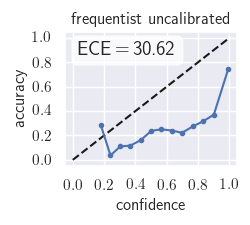

In [10]:
fig_freq_uc, ax_freq_uc = plot_conf(acc_freq_uc, conf_freq_uc)

textstr_freq_uc = r'ECE\,=\,{:.2f}'.format(ece_freq_uc.item()*100)
props = dict(boxstyle='round', facecolor='white', alpha=0.75)
ax_freq_uc.text(0.075, 0.925, textstr_freq_uc, transform=ax_freq_uc.transAxes, fontsize=14,
                verticalalignment='top',
                horizontalalignment='left',
                bbox=props
                )
ax_freq_uc.set_title(r'frequentist uncalibrated')
fig_freq_uc.tight_layout()
fig_freq_uc.show()

100%|██████████| 79/79 [00:03<00:00, 25.66it/s]

ece = 23.981624841690063
uce = 29.621928930282593


<IPython.core.display.Javascript object>


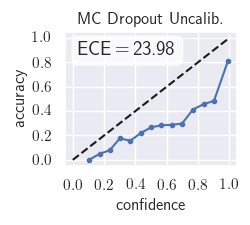

<IPython.core.display.Javascript object>


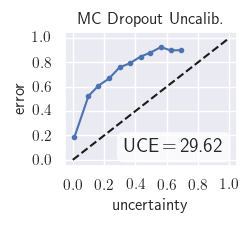

In [11]:
logits, labels = test(bayesian_net, temp_scale=False, bayesian=True)

ece1, acc1, conf1 = eceloss(logits, labels)
uce1, err1, entr1 = uceloss(logits, labels)

print('ece =', ece1.item()*100)
print("uce =", uce1.item()*100)

fig1, ax1 = plot_conf(acc1, conf1)
fig2, ax2 = plot_uncert(err1, entr1)

textstr1 = r'ECE\,=\,{:.2f}'.format(ece1.item()*100)
props = dict(boxstyle='round', facecolor='white', alpha=0.75)
ax1.text(0.075, 0.925, textstr1, transform=ax1.transAxes, fontsize=14,
         verticalalignment='top',
         horizontalalignment='left',
         bbox=props
        )
ax1.set_title(r'MC Dropout Uncalib.')
fig1.tight_layout()
fig1.show()

textstr2 = r'UCE\,=\,{:.2f}'.format(uce1.item()*100)
ax2.text(0.925, 0.075, textstr2, transform=ax2.transAxes, fontsize=14,
         verticalalignment='bottom',
         horizontalalignment='right',
         bbox=props
        )
ax2.set_title(r'MC Dropout Uncalib.')
fig2.tight_layout()
fig2.show()

100%|██████████| 79/79 [00:03<00:00, 27.01it/s]

ece = 0.06097187101840973


<IPython.core.display.Javascript object>


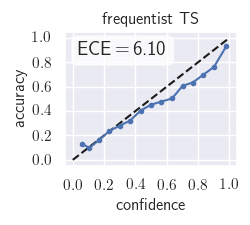

In [12]:
logits, labels = test(freq_net, temp_scale=True, bayesian=False)

ece_freq_ts, acc_freq_ts, conf_freq_ts = eceloss(logits, labels)
print('ece =', ece_freq_ts.item())

fig_freq_ts, ax_freq_ts = plot_conf(acc_freq_ts, conf_freq_ts)

textstr_freq_ts = r'ECE\,=\,{:.2f}'.format(ece_freq_ts.item()*100)
props = dict(boxstyle='round', facecolor='white', alpha=0.75)
ax_freq_ts.text(0.075, 0.925, textstr_freq_ts, transform=ax_freq_ts.transAxes, fontsize=14,
                verticalalignment='top',
                horizontalalignment='left',
                bbox=props
                )
ax_freq_ts.set_title(r'frequentist TS')
fig_freq_ts.tight_layout()
fig_freq_ts.show()

100%|██████████| 79/79 [00:03<00:00, 26.23it/s]

ece = 2.894381061196327
uce = 2.689840644598007


<IPython.core.display.Javascript object>


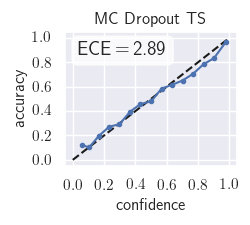

<IPython.core.display.Javascript object>


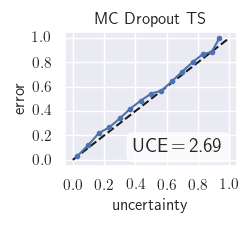

In [13]:
logits2, labels2 = test(bayesian_net, temp_scale=True, bayesian=True)

ece2, acc2, conf2 = eceloss(logits2, labels2)
uce2, err2, entr2 = uceloss(logits2, labels2)

print('ece =', ece2.item()*100)
print("uce =", uce2.item()*100)

fig3, ax3 = plot_conf(acc2, conf2)
fig4, ax4 = plot_uncert(err2, entr2)

textstr3 = r'ECE\,=\,{:.2f}'.format(ece2.item()*100)
props = dict(boxstyle='round', facecolor='white', alpha=0.75)
ax3.text(0.075, 0.925, textstr3, transform=ax3.transAxes, fontsize=14,
        verticalalignment='top',
        horizontalalignment='left',
        bbox=props
        )
ax3.set_title(r'MC Dropout TS')
fig3.tight_layout()
fig3.show()

textstr4 = r'UCE\,=\,{:.2f}'.format(uce2.item()*100)
ax4.text(0.925, 0.075, textstr4, transform=ax4.transAxes, fontsize=14,
         verticalalignment='bottom',
         horizontalalignment='right',
         bbox=props
         )
ax4.set_title(r'MC Dropout TS')
fig4.tight_layout()
fig4.show()

<IPython.core.display.Javascript object>


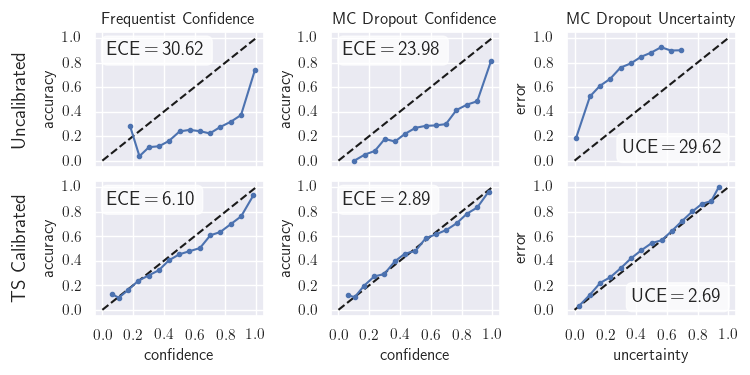

In [15]:
# compose final figure
fig_uc, ax_uc = plt.subplots(2, 3, figsize=(7.5, 3.75), sharex=True, sharey=False)

ax_uc[0,0].plot([0,1], [0,1], 'k--')
ax_uc[0,0].plot(conf_freq_uc.data.cpu().numpy(), acc_freq_uc.data.cpu().numpy(), marker='.')
#ax_uc[0,0].set_xlabel(r'confidence')
ax_uc[0,0].set_ylabel(r'accuracy')
ax_uc[0,0].set_xticks((np.arange(0, 1.1, step=0.2)))
ax_uc[0,0].set_yticks((np.arange(0, 1.1, step=0.2)))
ax_uc[0,0].set_title(r'Frequentist Confidence')
ax_uc[0,0].text(0.075, 0.925, textstr_freq_uc, transform=ax_uc[0,0].transAxes, fontsize=14,
                verticalalignment='top',
                horizontalalignment='left',
                bbox=props
                )

ax_uc[0,1].plot([0,1], [0,1], 'k--')
ax_uc[0,1].plot(conf1.data.cpu().numpy(), acc1.data.cpu().numpy(), marker='.')
ax_uc[0,1].set_xticks((np.arange(0, 1.1, step=0.2)))
ax_uc[0,1].set_yticks((np.arange(0, 1.1, step=0.2)))
ax_uc[0,1].set_ylabel(r'accuracy')
#ax_uc[0,1].set_xlabel(r'confidence')
ax_uc[0,1].set_title(r'MC Dropout Confidence')
ax_uc[0,1].text(0.075, 0.925, textstr1, transform=ax_uc[0,1].transAxes, fontsize=14,
                verticalalignment='top',
                horizontalalignment='left',
                bbox=props
                )

ax_uc[0,2].plot([0,1], [0,1], 'k--')
ax_uc[0,2].plot(entr1.data.cpu().numpy(), err1.data.cpu().numpy(), marker='.')
ax_uc[0,2].set_xticks((np.arange(0, 1.1, step=0.2)))
ax_uc[0,2].set_yticks((np.arange(0, 1.1, step=0.2)))
ax_uc[0,2].set_ylabel(r'error')
#ax_uc[0,2].set_xlabel(r'uncertainty')
ax_uc[0,2].set_title(r'MC Dropout Uncertainty')
ax_uc[0,2].text(0.925, 0.075, textstr2, transform=ax_uc[0,2].transAxes, fontsize=14,
                verticalalignment='bottom',
                horizontalalignment='right',
                bbox=props
                )


ax_uc[0,0].annotate(r'Uncalibrated', xy=(0, 0.5), xytext=(-ax_uc[0,0].yaxis.labelpad - 5, 0),
                    xycoords=ax_uc[0,0].yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center', fontsize=14, rotation=90)


ax_uc[1,0].plot([0,1], [0,1], 'k--')
ax_uc[1,0].plot(conf_freq_ts.data.cpu().numpy(), acc_freq_ts.data.cpu().numpy(), marker='.')
ax_uc[1,0].set_xlabel(r'confidence')
ax_uc[1,0].set_ylabel(r'accuracy')
ax_uc[1,0].set_xticks((np.arange(0, 1.1, step=0.2)))
ax_uc[1,0].set_yticks((np.arange(0, 1.1, step=0.2)))
#ax_uc[1,0].set_title(r'frequentist')
ax_uc[1,0].text(0.075, 0.925, textstr_freq_ts, transform=ax_uc[1,0].transAxes, fontsize=14,
                verticalalignment='top',
                horizontalalignment='left',
                bbox=props
                )

ax_uc[1,1].plot([0,1], [0,1], 'k--')
ax_uc[1,1].plot(conf2.data.cpu().numpy(), acc2.data.cpu().numpy(), marker='.')
ax_uc[1,1].set_xticks((np.arange(0, 1.1, step=0.2)))
ax_uc[1,1].set_yticks((np.arange(0, 1.1, step=0.2)))
ax_uc[1,1].set_ylabel(r'accuracy')
ax_uc[1,1].set_xlabel(r'confidence')
#ax_uc[1,1].set_title(r'MC dropout')
ax_uc[1,1].text(0.075, 0.925, textstr3, transform=ax_uc[1,1].transAxes, fontsize=14,
                verticalalignment='top',
                horizontalalignment='left',
                bbox=props
                )

ax_uc[1,2].plot([0,1], [0,1], 'k--')
ax_uc[1,2].plot(entr2.data.cpu().numpy(), err2.data.cpu().numpy(), marker='.')
ax_uc[1,2].set_xticks((np.arange(0, 1.1, step=0.2)))
ax_uc[1,2].set_yticks((np.arange(0, 1.1, step=0.2)))
ax_uc[1,2].set_ylabel(r'error')
ax_uc[1,2].set_xlabel(r'uncertainty')
#ax_uc[1,2].set_title(r'MC dropout')
ax_uc[1,2].text(0.925, 0.075, textstr4, transform=ax_uc[1,2].transAxes, fontsize=14,
                verticalalignment='bottom',
                horizontalalignment='right',
                bbox=props
                )

ax_uc[1,0].annotate(r'TS Calibrated', xy=(0, 0.5), xytext=(-ax_uc[1,0].yaxis.labelpad - 5, 0),
                    xycoords=ax_uc[1,0].yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center', fontsize=14, rotation=90)

fig_uc.tight_layout()
fig_uc.show()
fig_uc.savefig(f'{model}_composed.pdf', bbox_inches='tight')